In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, average_precision_score, precision_recall_curve
from sklearn.metrics import fbeta_score, roc_auc_score, roc_curve

In [2]:
data = pd.read_csv('creditcard.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
# Every column is normalised except 'Amount'
scaler = StandardScaler()
data['Amount'] = scaler.fit_transform(data[['Amount']])

In [ ]:
data = data.drop('Time', axis=1)

x_data = data.drop('Class', axis=1)
y_data = data['Class']

y_data = np.where(y_data == 1, -1, 1)

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2)

In [6]:
param_grid = {
  'n_estimators': [100, 150, 200],
  'max_samples': [0.6, 0.8, 1.0],
  'contamination': [0.0017, 0.0035, 0.0050],
  'max_features': [0.5, 0.7, 0.9]
}

In [ ]:
contamination = y_data.mean()

model = IsolationForest()
grid_search = GridSearchCV(model, param_grid=param_grid, scoring='f1_macro', cv=3, n_jobs=-1)

grid_search.fit(x_train, y_train)
best_model = grid_search.best_estimator_
print(f"Best Params: {best_model}")

/home/kartikag234/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kartikag234/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/kartikag234/.local/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/kartikag234/.local/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^

KeyboardInterrupt: 

In [9]:
y_predicted = best_model.predict(x_test)

# Map predictions: anomaly -> 1 and normal -> 0
y_predicted = [1 if y == -1 else 0 for y in y_predicted]

In [10]:
print(confusion_matrix(y_test, y_predicted))

[[56799    63]
 [   62    38]]


In [11]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56862
           1       0.38      0.38      0.38       100

    accuracy                           1.00     56962
   macro avg       0.69      0.69      0.69     56962
weighted avg       1.00      1.00      1.00     56962



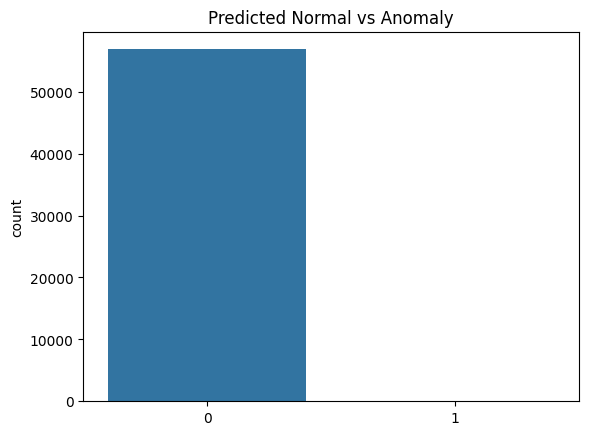

In [12]:
sns.countplot(x=y_predicted)
plt.title('Predicted Normal vs Anomaly')
plt.show()

In [14]:
scores = -grid_search.decision_function(x_test)
print(f"Anomalous Scores: {scores}")

Anomalous Scores: [-0.21769781 -0.21541473 -0.21172853 ... -0.21031114 -0.20673565
 -0.19364515]


In [15]:
ap_score = average_precision_score(y_test, scores)
print(f"Average Precision Score: {ap_score}")

Average Precision Score: 0.2926120822361065


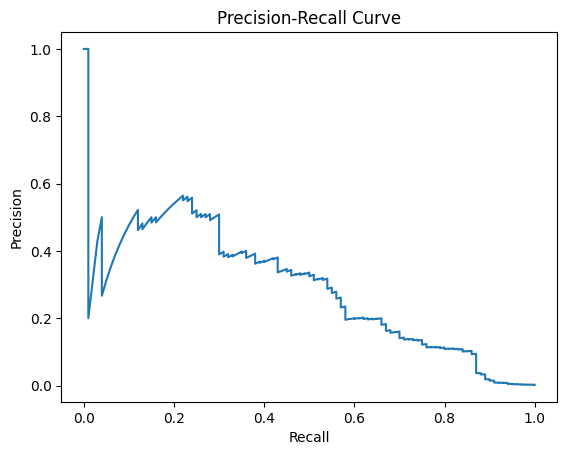

In [16]:
precision, recall, _ = precision_recall_curve(y_test, scores)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

In [17]:
f2 = fbeta_score(y_test, y_predicted, beta=2)
print(f"F2-Score: {f2}")

F2-Score: 0.37924151696606784


In [18]:
roc_score = roc_auc_score(y_test, scores)
print(f"ROC Score: {roc_score}")

ROC Score: 0.9552222925679715


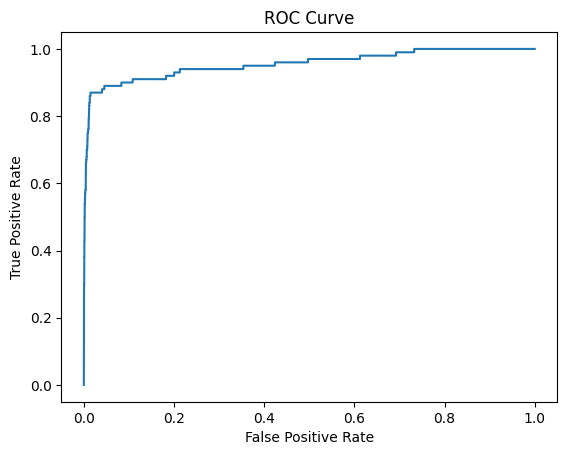

In [19]:
fpr, tpr, _ = roc_curve(y_test, scores)
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()